3. Lost in the closet (Classification)

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
import random

train_set = torchvision.datasets.FashionMNIST(root = ".", train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
# Fix the seed to be able to get the same randomness across runs and
# hence reproducible outcomes
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# If you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Visualise data for the first element of the batch:
(since the batch is set will allways display same picture)

Label is: 9
Dimension of input data: torch.Size([32, 1, 28, 28])
Dimension of labels: torch.Size([32])


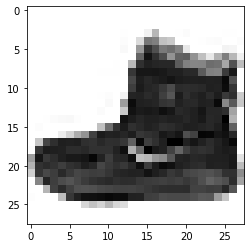

In [ ]:
input_data, label = next(iter(train_loader))
plt.imshow(input_data[0,:,:,:].numpy().reshape(28,28), cmap="gray_r");
print("Label is: {}".format(label[0]))
print("Dimension of input data: {}".format(input_data.size()))
print("Dimension of labels: {}".format(label.size()))

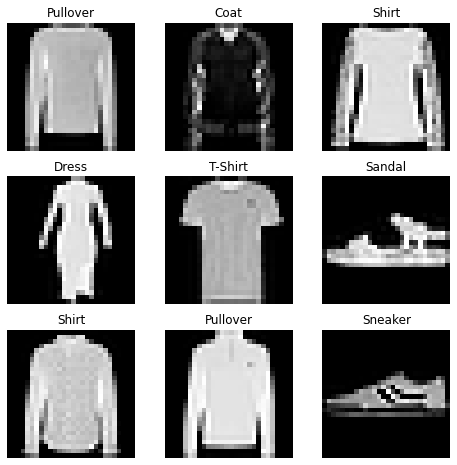

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 3;
rows = 3;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

1) Given the problem, what is the most appropriate loss function to use?

2) Create and train a Convolutional Neural Network corresponding to the following architecture: 

    1. Input image size: 28 × 28 × 1 (height × width × number of channels).
    2. First convolutional layer: Kernel size (5 × 5), Stride size (1 × 1) and 32 output channels. Activation function.
    3. Max pooling layer: Kernel size (2 × 2) and Stride size (2 × 2).
    4. Second convolutional layer: Kernel size (5×5), Stride size (1 × 1) and 64 output channels. Activation function.
    5. Max pooling layer: Kernel size (2 × 2) and Stride size (2 × 2).
    6. First fully-connected layer with input size being the output size of max pooling layer in 5.(flattened, i.e. 1024) and output size 1024. Activation function.
    7. Second fully-connected layer with input size being the output size of fully connected layer in (i.e. 1024) and output size 256. Activation function.
    8. Output layer with input size being the output size of fully-connected layer in 7. (i.e. 256) and output size 10.

In [ ]:
# Build the neural network, expand on top of nn.Module
class MyCNN(nn.Module):
    def __init__(self,num_classes=10,activation="relu",dropout_rate=0,training_flag=True):
        super(MyCNN, self).__init__()

        self.num_classes = num_classes # 10 here
        self.activation = activation # which activation function to employ
        self.dropout_rate = dropout_rate # if dropout then  how much
        self.training_flag = training_flag # if dropout then trainable or not

        if self.activation == "relu":
          self.cnn_model1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=5,stride=1), nn.ReLU(), nn.MaxPool2d(2,stride=2), nn.Conv2d(32,64,kernel_size=5,stride=1), nn.ReLU(), nn.MaxPool2d(2,stride=2))
          self.fc_model = nn.Sequential(nn.Linear(1024,256), nn.ReLU(), nn.Linear(256,10), nn.ReLU())
        # set different activation frunction for task 3
        if self.activation == "tanh":
          self.cnn_model1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=5,stride=1), nn.Tanh(), nn.MaxPool2d(2,stride=2), nn.Conv2d(32,64,kernel_size=5,stride=1), nn.Tanh(), nn.MaxPool2d(2,stride=2))
          self.fc_model = nn.Sequential(nn.Linear(1024,256), nn.Tanh(), nn.Linear(256,10), nn.Tanh())
        if self.activation == "sigmoid":
          self.cnn_model1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=5,stride=1), nn.Sigmoid(), nn.MaxPool2d(2,stride=2), nn.Conv2d(32,64,kernel_size=5,stride=1), nn.Sigmoid(), nn.MaxPool2d(2,stride=2))
          self.fc_model = nn.Sequential(nn.Linear(1024,256), nn.Sigmoid(), nn.Linear(256,10), nn.Sigmoid())
        if self.activation == "elu":
          self.cnn_model1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=5,stride=1), nn.ELU(), nn.MaxPool2d(2,stride=2), nn.Conv2d(32,64,kernel_size=5,stride=1), nn.ELU(), nn.MaxPool2d(2,stride=2))
          self.fc_model = nn.Sequential(nn.Linear(1024,256), nn.ELU(), nn.Linear(256,10), nn.ElU())
        # set dropout layer
        if self.dropout_rate != 0:
          self.cnn_model1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=5,stride=1), nn.ReLU(), nn.MaxPool2d(2,stride=2), nn.Conv2d(32,64,kernel_size=5,stride=1), nn.ReLU(), nn.MaxPool2d(2,stride=2))
          self.fc_model = nn.Sequential(nn.Linear(1024,256), nn.ReLU(), nn.Dropout(self.dropout_rate), nn.Linear(256,10), nn.ReLU(), nn.Dropout(self.dropout_rate))          

    def forward(self, t):

        t = self.cnn_model1(t)
        t = t.view(t.size(0), -1)
        t = self.fc_model(t)

        return t

In [ ]:

def train(model,x,y,criterion,optimizer):

    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(x)
    # compute the loss
    loss = criterion(outputs, y)
    # calculate gradient
    loss.backward()
    # update parametres
    optimizer.step()

    return loss.item()

def evaluation(model,loader):

    # evaluation function
    correct = 0
    total = 0
    # turn off dropout layer
    model.eval()
    # torch.no_grad prevents backward recording, reduces memory consumtion
    with torch.no_grad():
    
        for i, (images,labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            # since no_grad is used, generate autograd for this part of evaluation
            images = torch.autograd.Variable(images.float())
            labels = torch.autograd.Variable(labels)

            outputs = model(images)
            # the class with highest value is chosen for prediction
            # the result tuple of two output tensors (max, max_indices)
            # take only indices
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total if total > 0 else 0

In [ ]:
def classify(device,model,data,criterion,optimizer,*params):
    # Function to perform classifications with different parametres
    num_epochs,num_classes,batch_size,learning_rate,activation = params
    train_loader,test_loader = data
    # define parametres
    total_step = len(train_loader)
    train_losses = []
    train_accuracy = []
    test_accuracy = []
    tte = [] # time taken per epoch
    loss_epoch_array = []

    # start loop that goes through all epoch
    for epoch in range(num_epochs):
        loss_epoch = 0
        tte_start = time.time()
        # loop over batches
        for i, (images,labels) in enumerate(train_loader):
            # to ensure dropout is "turned on" while training, is set to 0 in all tasks but last
            model.train()
            # since no_grad is used, generate autograd for this part of evaluation
            images, labels = images.to(device), labels.to(device)
            images = torch.autograd.Variable(images.float())
            labels = torch.autograd.Variable(labels)

            loss = train(model,images,labels,criterion,optimizer)
            loss_epoch += loss
        # append the results and update time
        train_losses.append(loss)
        train_accuracy.append(evaluation(model,train_loader))
        test_accuracy.append(evaluation(model,test_loader))
        loss_epoch_array.append(loss_epoch)
        tte_end = time.time()
        elapsed_time = tte_end-tte_start
        tte.append(elapsed_time)
        # print results as soon as epoch ends
        print ('Epoch [{}/{}] {:.2f} sec, loss_epoch: {:.2f} ,train_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch+1, num_epochs, elapsed_time,loss_epoch,train_losses[-1], train_accuracy[-1],test_accuracy[-1]))
    # print final results
    final_test_accuracy = evaluation(model,test_loader)
    print('Test Accuracy of the model: {:.4f} %'.format(100 * final_test_accuracy))
    print('Total Time taken: {:.3f} sec'.format(sum(tte)))
    return train_losses, train_accuracy, test_accuracy, final_test_accuracy, elapsed_time, loss_epoch_array

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
    torch.nn.init.xavier_normal_(m.weight)

For training, initialise your weights using the Xavier Uniform initialisation, use ReLU as the activation function, a learning rate of 0.1 with the SGD optimiser. Train neural network 30 epochs.

 a) Obtain accuracy

In [ ]:
result = []
num_epochs = 30
num_classes = 10
batch_size = 100
learning_rate = 0.1
activation = "relu"
dropout_rate = 0
training_flag = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = MyCNN(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
# initialise weights
net.apply(weights_init)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(net.parameters()), lr=learning_rate)
data = train_loader, test_loader
[train_loader,test_loader] = data 

t_loss,t_acc,test_acc,final_test_accuracy,exec_time, loss_epoch_array = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,t_acc,test_acc,final_test_accuracy,exec_time]
result.append(end)

Epoch [1/30] 28.64 sec, loss_epoch: 1176.69 ,train_loss: 0.3563, train_acc: 0.8657, test_acc: 0.8542
Epoch [2/30] 29.94 sec, loss_epoch: 644.88 ,train_loss: 0.2515, train_acc: 0.8891, test_acc: 0.8742
Epoch [3/30] 28.90 sec, loss_epoch: 550.22 ,train_loss: 0.2086, train_acc: 0.9024, test_acc: 0.8827
Epoch [4/30] 28.26 sec, loss_epoch: 490.61 ,train_loss: 0.2068, train_acc: 0.9113, test_acc: 0.8892
Epoch [5/30] 28.61 sec, loss_epoch: 444.88 ,train_loss: 0.2224, train_acc: 0.9172, test_acc: 0.8939
Epoch [6/30] 28.27 sec, loss_epoch: 404.78 ,train_loss: 0.1984, train_acc: 0.9202, test_acc: 0.8955
Epoch [7/30] 28.29 sec, loss_epoch: 370.45 ,train_loss: 0.2080, train_acc: 0.9244, test_acc: 0.8982
Epoch [8/30] 28.40 sec, loss_epoch: 338.48 ,train_loss: 0.1972, train_acc: 0.9253, test_acc: 0.8962
Epoch [9/30] 28.23 sec, loss_epoch: 309.60 ,train_loss: 0.2333, train_acc: 0.9289, test_acc: 0.8986
Epoch [10/30] 28.18 sec, loss_epoch: 282.95 ,train_loss: 0.2259, train_acc: 0.9289, test_acc: 0.896

b) Plot Accuracy

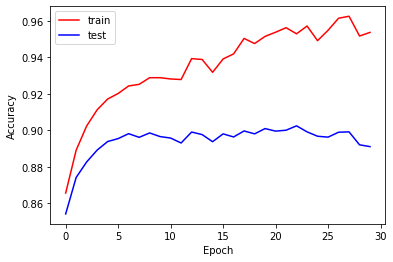

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(t_acc, "r")
plt.plot(test_acc, "b")
plt.gca().legend(('train','test'))

c) Plot of the train loss per epoch

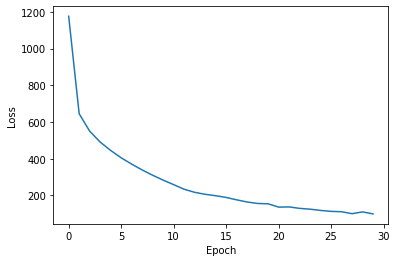

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

3. Tanh, Sigmoid and ELU

In [ ]:
for activation in ["tanh","sigmoid","elu"]:
    num_epochs = 30
    num_classes = 10
    batch_size = 100
    learning_rate = 0.1
    dropout_rate = 0
    # activations = ["tanh","sigmoid","elu"]
    print(activation)
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = MyCNN(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    data = train_loader, test_loader
    [train_loader,test_loader] = data 

    t_loss,t_acc,test_acc,final_test_accuracy,exec_time, loss_epoch_array = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,t_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

tanh
Epoch [1/30] 28.39 sec, loss_epoch: 1154.89 ,train_loss: 0.4144, train_acc: 0.8715, test_acc: 0.8596
Epoch [2/30] 28.15 sec, loss_epoch: 622.09 ,train_loss: 0.3204, train_acc: 0.8930, test_acc: 0.8768
Epoch [3/30] 28.10 sec, loss_epoch: 528.00 ,train_loss: 0.2794, train_acc: 0.9037, test_acc: 0.8865
Epoch [4/30] 28.14 sec, loss_epoch: 468.36 ,train_loss: 0.2666, train_acc: 0.9145, test_acc: 0.8966
Epoch [5/30] 28.03 sec, loss_epoch: 421.68 ,train_loss: 0.2439, train_acc: 0.9178, test_acc: 0.8973
Epoch [6/30] 35.63 sec, loss_epoch: 381.61 ,train_loss: 0.2491, train_acc: 0.9254, test_acc: 0.9002
Epoch [7/30] 30.03 sec, loss_epoch: 345.91 ,train_loss: 0.2562, train_acc: 0.9253, test_acc: 0.8969
Epoch [8/30] 28.13 sec, loss_epoch: 310.79 ,train_loss: 0.2288, train_acc: 0.9267, test_acc: 0.8980
Epoch [9/30] 28.23 sec, loss_epoch: 280.32 ,train_loss: 0.2125, train_acc: 0.9329, test_acc: 0.8999
Epoch [10/30] 29.17 sec, loss_epoch: 248.32 ,train_loss: 0.1463, train_acc: 0.9346, test_acc: 

4. 5 different learning rates: 0.001, 0.1, 0.5, 1, 10

In [ ]:
for learning_rate in [0.001,0.5,1,10]:
    num_epochs = 30
    num_classes = 10
    batch_size = 100
#     learning_rate = 0.1
    activation = "relu"
    dropout_rate = 0
    print(learning_rate)
    training_flag = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = MyCNN(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    data = train_loader, test_loader
    [train_loader,test_loader] = data 

    t_loss,t_acc,test_acc,final_test_accuracy,exec_time, loss_epoch_array = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
    end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,t_acc,test_acc,final_test_accuracy,exec_time]
    result.append(end)

0.001
Epoch [1/30] 28.15 sec, loss_epoch: 4263.92 ,train_loss: 2.2356, train_acc: 0.3297, test_acc: 0.3291
Epoch [2/30] 28.39 sec, loss_epoch: 3788.65 ,train_loss: 1.8823, train_acc: 0.3921, test_acc: 0.3913
Epoch [3/30] 28.75 sec, loss_epoch: 3148.15 ,train_loss: 1.7372, train_acc: 0.5127, test_acc: 0.5064
Epoch [4/30] 28.19 sec, loss_epoch: 2742.24 ,train_loss: 1.6284, train_acc: 0.5233, test_acc: 0.5176
Epoch [5/30] 28.07 sec, loss_epoch: 2587.11 ,train_loss: 1.5869, train_acc: 0.5312, test_acc: 0.5270
Epoch [6/30] 28.09 sec, loss_epoch: 2504.78 ,train_loss: 1.5626, train_acc: 0.5368, test_acc: 0.5334
Epoch [7/30] 28.17 sec, loss_epoch: 2448.42 ,train_loss: 1.5426, train_acc: 0.5412, test_acc: 0.5375
Epoch [8/30] 28.20 sec, loss_epoch: 2371.57 ,train_loss: 1.4529, train_acc: 0.6288, test_acc: 0.6257
Epoch [9/30] 28.07 sec, loss_epoch: 2084.96 ,train_loss: 1.4277, train_acc: 0.6324, test_acc: 0.6282
Epoch [10/30] 28.07 sec, loss_epoch: 2033.18 ,train_loss: 1.4025, train_acc: 0.6354, 

In [ ]:
result = []
num_epochs = 30
num_classes = 10
batch_size = 100
learning_rate = 0.1
activation = "relu"
dropout_rate = 0.3
training_flag = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = MyCNN(num_classes,activation=activation,dropout_rate=dropout_rate,training_flag=training_flag).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
data = train_loader, test_loader
[train_loader,test_loader] = data 

t_loss,t_acc,test_acc,final_test_accuracy,exec_time, loss_epoch_array = classify(device,net,data,criterion,optimizer,num_epochs,num_classes,batch_size,learning_rate,activation)
end = [learning_rate,activation,dropout_rate,num_epochs,t_loss,t_acc,test_acc,final_test_accuracy,exec_time]
result.append(end)

Epoch [1/30] 28.52 sec, loss_epoch: 2426.72 ,train_loss: 0.8025, train_acc: 0.8526, test_acc: 0.8473
Epoch [2/30] 28.40 sec, loss_epoch: 1947.75 ,train_loss: 1.1338, train_acc: 0.8871, test_acc: 0.8737
Epoch [3/30] 28.54 sec, loss_epoch: 1872.37 ,train_loss: 1.0407, train_acc: 0.8954, test_acc: 0.8835
Epoch [4/30] 28.42 sec, loss_epoch: 1813.18 ,train_loss: 0.9080, train_acc: 0.9068, test_acc: 0.8910
Epoch [5/30] 28.40 sec, loss_epoch: 1780.13 ,train_loss: 1.2545, train_acc: 0.9132, test_acc: 0.8954
Epoch [6/30] 28.45 sec, loss_epoch: 1749.44 ,train_loss: 0.8773, train_acc: 0.9109, test_acc: 0.8912
Epoch [7/30] 28.44 sec, loss_epoch: 1733.81 ,train_loss: 0.9724, train_acc: 0.9231, test_acc: 0.9003
Epoch [8/30] 28.50 sec, loss_epoch: 1722.62 ,train_loss: 1.0108, train_acc: 0.9216, test_acc: 0.8995
Epoch [9/30] 28.44 sec, loss_epoch: 1680.74 ,train_loss: 0.9499, train_acc: 0.9278, test_acc: 0.8989
Epoch [10/30] 28.46 sec, loss_epoch: 1671.06 ,train_loss: 0.8185, train_acc: 0.9304, test_a